# UNSUPERVISED MODELLING

In this stage of the project, customer segmentation based on unsupervised modelling will be developed by applying the Kmeans algorithm, in order to find new insights which help to improve company's sales and marketing campaigns and so increase lead-to-customer conversion rate.

## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='dark',palette='pastel')

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from sklearn.model_selection import GridSearchCV

#To increase autocomplete response speed
%config IPCompleter.greedy=True

#Disabling scientific notation
pd.options.display.float_format = '{:.2f}'.format

#Disabling warnings
import warnings
warnings.filterwarnings("ignore")

## DATA IMPORTATION

Replace project path.

In [2]:
project_path = (r'C:\Users\pedro\PEDRO\DS\Portfolio\LEAD_SCORING').replace('\\','/')

Names of data files.

In [3]:
df_name = 'df_input.pickle'

Data importation.

In [4]:
df = pd.read_pickle(project_path + '/02_Data/03_Work/' + df_name)

After an iterative process, it was decided not to consider all features to perform the segmentation:

In [5]:
include = '|'.join(['lead_origin','last_activity','ocupation','total_time_website','converted'])

In [6]:
df = df.loc[:,df.columns.str.contains(include)]

In [7]:
df.columns.to_list()

['lead_origin_API',
 'lead_origin_Landing Page Submission',
 'lead_origin_Lead Add Form',
 'lead_origin_Others',
 'last_activity_Converted to Lead',
 'last_activity_Email Link Clicked',
 'last_activity_Email Opened',
 'last_activity_Form Submitted on Website',
 'last_activity_Olark Chat Conversation',
 'last_activity_Others',
 'last_activity_Page Visited on Website',
 'last_activity_SMS Sent',
 'last_activity_Unknown',
 'ocupation_Others',
 'ocupation_Student',
 'ocupation_Unemployed',
 'ocupation_Working Professional',
 'total_time_website_mms',
 'converted']

Extracting features and target:

In [8]:
x = df
y = df[['converted']]

## MODELLING

### Reserving validation dataset

In [9]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.35)

### Creating solution space

In [10]:
min_k = 2
max_k = 8

solutions = list(range(min_k,max_k))

### Creating lists to store the output of each metric

In [11]:
elbow = []
silhouette = []
calinski = []
davies = []

### Analysing solution space

In [12]:
for solution in solutions:
    
    #Instantiating
    cluster = KMeans(n_clusters = solution, n_init=10)
    
    #Training
    cluster.fit(train_x)
    
    #Metrics
    elbow.append(cluster.inertia_)
    silhouette.append(silhouette_score(train_x, cluster.labels_))
    calinski.append(calinski_harabasz_score(train_x, cluster.labels_))
    davies.append(davies_bouldin_score(train_x, cluster.labels_))

### Identifying the best number of clusters

In this section, different methods will be used to identify the optimal number of clusters to be considered in the application of the Kmeans algorithm.

#### Metrics analysis

In [28]:
metrics = pd.DataFrame({'Solution (number of clusters)':solutions,
                        'Elbow': elbow,
                        'Silhouette':silhouette,
                        'Calinski-Harabasz':calinski,           
                        'Davies-Bouldin':davies}).set_index('Solution (number of clusters)')

metrics

,Elbow,Silhouette,Calinski-Harabasz,Davies-Bouldin
Solution (number of clusters),,,,
2,6196.53,0.28,1550.70,1.61
3,5181.24,0.30,1380.53,1.51
4,4614.22,0.31,1222.76,1.42
5,4027.37,0.35,1218.99,1.41
6,3548.19,0.39,1231.58,1.38
7,3092.99,0.43,1290.52,1.26


#### Graphical analysis

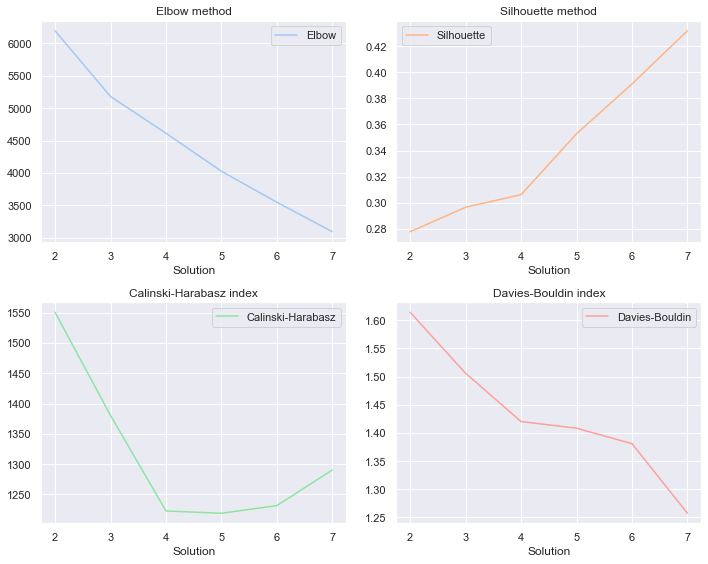

In [14]:
metrics.plot(subplots = True, figsize = (10,8), layout = (2,2), sharex = False, grid=True,
             title=['Elbow method',
                    'Silhouette method',
                    'Calinski-Harabasz index',
                    'Davies-Bouldin index']);
plt.tight_layout()

Analysing the above graphs, it can be seen that:
- **Elbow method:** It does not provide useful information in this case as it shows a linear decrease in errors.

- **Silhouette method:** Better results with increasing number of clusters.

- **Calinski-Harabasz index:** 2 or 3 clusters provide the best solutions. Results with 6 or 7 clusters are better than with 4 or 5.

- **Davies-Bouldin index:** Better results with increasing number of clusters.


### Final segmentation using the best number of clusters

In [15]:
best_solution = 6

#Instantiating:
cluster = KMeans(n_clusters = best_solution, n_init=10)
    
#Training:
cluster.fit(train_x)

KMeans(n_clusters=6)

## EVALUATION

Checking that profiles obtained in training dataset are similar to those obtained when predicting using validation dataset.

### Calculating the segment in training and validation datasets.

In [16]:
train_x['segment'] = cluster.predict(train_x)

In [17]:
val_x['segment'] = cluster.predict(val_x)

### Comparing training and validation profiles

#### Calculating profiles

In [18]:
profiles_train = train_x.groupby('segment').mean().T.stack().reset_index()
profiles_train.columns = ['feature','segment','mean']

profiles_val = val_x.groupby('segment').mean().T.stack().reset_index()
profiles_val.columns = ['feature','segment','mean']

#### Comparing profiles

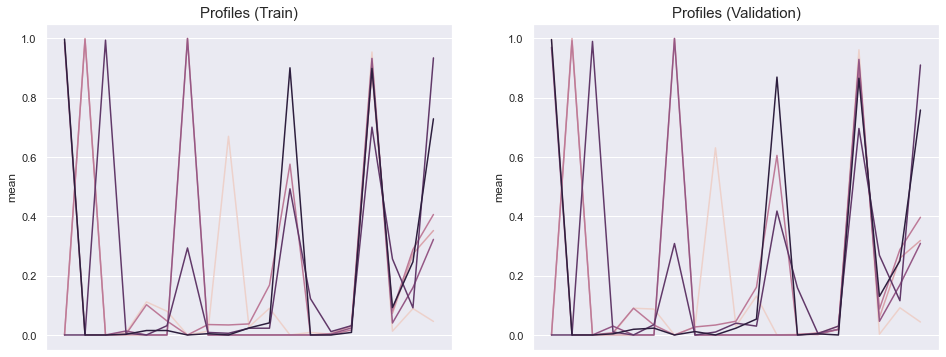

In [19]:
sns.set_style("darkgrid")

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))

sns.lineplot(ax = ax[0], data = profiles_train, x = 'feature', y = 'mean', hue = 'segment')
ax[0].get_legend().remove()
ax[0].axes.xaxis.set_visible(False)
ax[0].set_title('Profiles (Train)', fontsize=15)

sns.lineplot(ax = ax[1], data = profiles_val, x = 'feature', y = 'mean', hue = 'segment')
ax[1].get_legend().remove()
ax[1].axes.xaxis.set_visible(False)
ax[1].set_title('Profiles (Validation)', fontsize=15);

## PROFILING SEGMENTS

This section will profile the segments identified from a business analytics point of view.

In [20]:
train_x.groupby('segment').mean().T \
       .style.highlight_max(color = 'palegreen', axis = 1) \
       .highlight_min(color = 'lightcoral', axis = 1)

segment,0,1,2,3,4,5
lead_origin_API,0.991429,0.000000,0.000000,0.986567,0.000000,0.997849
lead_origin_Landing Page Submission,0.000000,1.000000,0.997183,0.000000,0.000000,0.000000
lead_origin_Lead Add Form,0.000000,0.000000,0.000000,0.000000,0.994302,0.000000
lead_origin_Others,0.008571,0.000000,0.002817,0.013433,0.005698,0.002151
last_activity_Converted to Lead,0.111429,0.000000,0.102113,0.000000,0.000000,0.015054
last_activity_Email Link Clicked,0.080000,0.000000,0.047183,0.000000,0.031339,0.015054
last_activity_Email Opened,0.000000,1.000000,0.000000,1.000000,0.293447,0.000000
last_activity_Form Submitted on Website,0.012857,0.000000,0.035211,0.000000,0.008547,0.004301
last_activity_Olark Chat Conversation,0.670000,0.000000,0.033803,0.000000,0.005698,0.000000
last_activity_Others,0.027143,0.000000,0.037324,0.000000,0.022792,0.023656


Train dataset - Percentage of total leads in each of the segments identified:

In [22]:
train_x.segment.value_counts(normalize=True).sort_index()

0   0.15
1   0.22
2   0.31
3   0.14
4   0.08
5   0.10
Name: segment, dtype: float64

In [23]:
val_x.groupby('segment').mean().T \
     .style.highlight_max(color = 'palegreen', axis = 1) \
     .highlight_min(color = 'lightcoral', axis = 1)

segment,0,1,2,3,4,5
lead_origin_API,0.997268,0.000000,0.000000,0.970190,0.000000,0.996169
lead_origin_Landing Page Submission,0.000000,1.000000,0.992268,0.000000,0.000000,0.000000
lead_origin_Lead Add Form,0.000000,0.000000,0.000000,0.000000,0.990050,0.000000
lead_origin_Others,0.002732,0.000000,0.007732,0.029810,0.009950,0.003831
last_activity_Converted to Lead,0.090164,0.000000,0.090206,0.000000,0.000000,0.019157
last_activity_Email Link Clicked,0.087432,0.000000,0.033505,0.000000,0.034826,0.022989
last_activity_Email Opened,0.000000,1.000000,0.000000,1.000000,0.308458,0.000000
last_activity_Form Submitted on Website,0.027322,0.000000,0.027062,0.000000,0.000000,0.011494
last_activity_Olark Chat Conversation,0.631148,0.000000,0.033505,0.000000,0.009950,0.000000
last_activity_Others,0.030055,0.000000,0.046392,0.000000,0.039801,0.022989


Validation dataset - Percentage of total leads in each of the segments identified:

In [24]:
val_x.segment.value_counts(normalize=True).sort_index()

0   0.15
1   0.21
2   0.31
3   0.15
4   0.08
5   0.10
Name: segment, dtype: float64

### Segment descriptions

**Segment 0**
- Origin: API.
- Last activity: Most leads have conversations via Olark chat.
- Segment with lower presence of working professionals.
- Time spent on the website far below average.
- Almost no leads in this segment buy the company's product.

**Segment 1**
- Origin: Landing Page.
- Last activity: Email Opened.
- Some presence of working professionals.
- Above-average time spent on the website.
- Slightly lower conversion rate than the company's current average conversion rate.

**Segment 2**
- Origin: Landing Page.
- Last activity: Most of them have received an SMS. Some of them have visited the website.
- Some presence of working professionals.
- Above-average time spent on the website.
- Slightly higher conversion rate than the company's current average conversion rate.

**Segment 3**
- Origin: API.
- Last activity: Email Opened.
- Some presence of working professionals.
- Below average time spent on website.
- Slightly lower conversion rate than the company's current one. Similar to the conversion rate of segment 1.

**Segment 4**
- Origin: Lead Add Form (main sources: References, Welingak website).
- Last activity: Email Opened, SMS sent or unknown.
- High presence of working professionals.
- Time spent on the website far below average.
- 9 out of 10 leads in this segment end up buying the company's product.

**Segment 5**
- Origin: API.
- Last activity: SMS sent.
- Notable presence of working professionals.
- Above-average time spent on the website.
- Conversion rate significantly higher than the company's current average conversion rate.

## Conclusions

1. The company's most valuable leads are those that come from referrals or from Welingak website, and even more so if they are working professionals. As proposed in the exploratory data analysis section, the company should seriously consider creating a referral programme to encourage existing customers to recommend the course to their close circle.


2. SMS campaigns are performing quite well. However, these campaigns should focus on:
    - Working professionals comming from API or landing page who spend above-average time on the website.
    - Leads comming from References or Welingak website regardless of their occupation and time spend on the website.
    - Avoid sending sms to leads who come from API and have spent a short time on the site.
    

3. Olark chat is not performing well. The company should consider withdrawing investment in this service and for leads coming from API replace it with:
    - Email marketing campaigns in case of working professionals who spent a short time on the website or in case of unemployed leads.
    - SMS campaigns in case of working professionals who spend above-average time on the website, as discussed in the previous point.